In [1]:
%%bash
pip install sklearn

You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import numpy as np

import os
import inspect
import sys
import pandas as pd
import charts
import time
import math
import datetime
import copy

from opengrid.library import houseprint
from scipy.spatial import distance
from scipy.signal import butter, lfilter, freqz
from scipy.signal import argrelextrema
from sklearn.cluster import MeanShift

from tqdm import tqdm
from time import sleep

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline
plt.rcParams['figure.figsize'] = 16,8

/usr/local/lib/python2.7/dist-packages/pandas/core/computation/__init__.py:18: UserWarning: The installed version of numexpr 2.2.2 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


Server running in the folder /usr/local/opengrid/notebooks/Analysis/Thesis_Max&Jean/Block_detection at 127.0.0.1:54083


In [3]:
hp = houseprint.Houseprint()

Opening connection to Houseprint sheet
Opening spreadsheets
Parsing spreadsheets
34 Sites created
34 Devices created
97 sensors created
Houseprint parsing complete


#### Get the data you want to check ####

In [4]:
device = hp.find_device('FL03001441')
device.get_sensors()

[
     Fluksosensor
     Key: 81fb589c911e808daa96a2064bebed41
     Type: electricity
     , 
     Fluksosensor
     Key: 212ce724e124fbde0fb649396375d099
     Type: gas
     , 
     Fluksosensor
     Key: c57f45b21e2ec21ab427f172478e1ca4
     Type: water
     , 
     Fluksosensor
     Key: 156e0abc64b00c5e98dbd3c17883b5f6
     Type: electricity
     , 
     Fluksosensor
     Key: e5306ee3a4235498592fc89ee0ede353
     Type: electricity
     ]

In [5]:
#Get Gas data
head = pd.Timestamp('20151110')
tail = pd.Timestamp('20151118')
electr = hp.find_sensor('212ce724e124fbde0fb649396375d099')
df_el = electr.get_data(head,tail,diff=True,resample='min',  unit='kW')
df_el_dropna = df_el.dropna()
df_el = pd.DataFrame(df_el)

Using tmpo database from /data/.tmpo/tmpo.sqlite3


/usr/local/lib/python2.7/dist-packages/tmpo/__init__.py:251: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  if isinstance(time, pd.tslib.Timestamp):
/usr/local/opengrid/opengrid/library/houseprint/sensor.py:280: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a series
by implicitly taking the mean.  Use .resample(...).mean() instead
  newindex = data.resample(rule).index


In [6]:
if df_el.size <= 0:
    print "Dataframe is empty"
    
charts.plot(df_el.rolling(window=6,center=False).median(), show="inline", stock=True)

# Blockdetection Functions #

 * Z-normalisation
 * PAA-transform
 * SAX-transform
 * Actual blockdetection

In [7]:
def znormalization(ts):
    """
        Args:
            ts (np.array)

        Returns:
            (np.array)
    """
    mus = ts.mean(axis = 0)
    stds = ts.std(axis = 0)
    return (ts - mus) / stds

In [8]:
def paa_transform(ts, n_pieces):
    """
        Args:
            ts (np.array)
            n_pieces (int) : M equally sized piecies into which the original ts is splitted
            
        Returns:
            (np.array) : ts's paa transformation
    """
    splitted = np.array_split(ts, n_pieces) ## along columns as we want
    return np.asarray(map(lambda xs: xs.mean(axis = 0), splitted))

In [9]:
def sax_transform(ts, n_pieces, alphabet):
    """
        Args:
            ts (np.array) 
            n_pieces (int) : number of segments in paa transformation
            alphabet (String) : the letters to be translated to, e.g. "abcd", "ab"
        
        Returns: 
            (np.array) : ts's sax transformation
            
    """
    from scipy.stats import norm
    alphabet_sz = len(alphabet)
    thrholds = norm.ppf(np.linspace(1./alphabet_sz, 
                                    1-1./alphabet_sz, 
                                    alphabet_sz-1))
    def translate(ts_values):
        return np.asarray([(alphabet[0] if ts_value < thrholds[0]
                else (alphabet[-1] if ts_value > thrholds[-1]
                      else alphabet[np.where(thrholds <= ts_value)[0][-1]+1]))
                           for ts_value in ts_values])
    paa_ts = paa_transform(znormalization(ts), n_pieces)
    return np.apply_along_axis(translate, 0, paa_ts)

In [10]:
def makeArray(array1):
    """
        Turn sax-transform letters back into numbers
        
        Args:
            array1 (pd.DataFrame)
        
        Returns:
            df (pd.DataFrame)
        
    """
    arrayValues=[]    
    for i in range(0, array1.size-1):
        if(i<array1.size):
             arrayValues.append(ord(array1.iloc[i])-97)
    df=pd.DataFrame(arrayValues)
    return df

In [11]:
def manhattanDistance(s1,s2):
    """
        Args:
            s1 (pd.DataFrame)
            s2 (pd.DataFrame)
        
        Returns:
            dist (Float) : Measure of the similarity of s1 and s2
    """
    dist = distance.cityblock(s1,s2)
    return dist

In [12]:
def check_max_consumption(start, stop, parent, threshold=4.0):
    """
        Check if the found block has a certain minimum consumption
        
        Args:
            start (timestamp) : date & time when the found block started
            stop (timestamp) : date & time when the found block ended
            parent (pd.DataFrame) : The parent of the found block
            threshold (int) : Minimum desired consumption
            
        Returns:
            True/ False
    """
    
    head = pd.Timestamp(start)
    tail = pd.Timestamp(stop)
    temp = parent.ix[head:tail]
    
    if float(temp.values.max() - temp.values.min()) < threshold:
        return False
    else:
        return True

In [13]:
def check_duplicate(blocks, start, stop):
    """
        Make sure a child block is different is not the same as its parent
    
        Args:
            blocks (pd.DataFrame) : List of all previously found blocks
            start (timestamp) : date & time when the found block started
            stop (timestamp) : date & time when the found block ended
            
        Return:
            True/ False
            blocks (pd.DataFrame) : List of all previously found blocks
    """
    
    start = pd.Timestamp(start)
    stop = pd.Timestamp(stop)
    
    
    for i in range(0, blocks.index.size):
        
        check_start = pd.Timestamp(blocks['start'].iloc[i])
        check_stop = pd.Timestamp(blocks['stop'].iloc[i])
    
        if start == check_start or stop == check_stop or (start > check_start and stop < check_stop):
            if (stop - start)/(check_stop - check_start) > 0.75:
                return False, blocks
            
        if start < check_start and stop > check_stop:
            if (check_stop - check_start)/(stop - start) > 0.75:
                blocks = blocks.drop(blocks.index[i])
                
            
    return True, blocks
    

In [14]:
def find_blocks(df_parent, row_parent, blocks, df_original, df_rm, first_time = True):
    """
        Args:
            df_parent (pd.DataFrame) : parent block
            row_parent (int) : index of the parent block
            blocks (pd.DataFrame) : List of all previously found blocks
            df_original (pd.DataFrame) : sax-equivalent
            first_time (Boolean)
            df_rm (pd.DataFrame) : rolling mean of orriginal
            
        Returns:
            blocks (pd.DataFrame) : List of all previously found blocks
            
    """
    
    
    min_lvl = 0
    start = False
    
    block_start = 0
    block_end = 0
    index_low = -1
    
    nr_of_blocks_start = blocks.size
    
    nested = row_parent
    
    if first_time:
        start = True
        min_lvl = df_parent['repeatedValues'].min()
        
    #append last value again
    post_index = df_parent.index[-1] + pd.Timedelta(minutes=1)

    temp = pd.DataFrame(data=[df_parent.iloc[-1]], index=[post_index], columns=['repeatedValues'])
    df_parent = df_parent.append(temp)

    df_parent.sort_index(inplace=True)

    for i in range(1, df_parent.size - 1):
        if start == False and df_parent['repeatedValues'].iloc[i - 1] - df_parent['repeatedValues'].iloc[i] == 0:
            min_lvl = df_parent['repeatedValues'].iloc[i]
            start = True
        
        if start == True and df_parent['repeatedValues'].iloc[i] > min_lvl and df_parent['repeatedValues'].iloc[i - 1] == min_lvl:
            block_start = df_parent.index[i - 1]
            
        if start == True and block_start != 0 and df_parent['repeatedValues'].iloc[i] <= min_lvl:
            block_end = df_parent.index[i]
            
            #Match if the length is more than 10% less than the parent
            temp = pd.DataFrame(data=[[str(block_start), str(block_end), nested]], columns=['start', 'stop', 'nested_in'])
            
            if float(df_parent.index.size - df_parent.ix[block_start : block_end].index.size) / float(df_parent.index.size) > 0.10:
                # check if block is longer than 15 min
                if(block_end - block_start > pd.Timedelta(minutes=15)):
                    # check max consumption is greater than threshold
                    if check_max_consumption(start=block_start, stop=block_end, parent=df_rm):
                        # Check for duplicates
                        check, blocks = check_duplicate(blocks, block_start, block_end)
                        if check:
                            #print [block_start, block_end]
                            blocks = blocks.append(temp, ignore_index=True)
            
            df_parent2 = df_original.ix[block_start : block_end]
            row_parent = blocks.index.size - 1
            blocks = find_blocks(df_parent2, row_parent, blocks, df_original, df_rm, False)
            blocks =  blocks.drop_duplicates(subset=['start', 'stop'], keep= 'first')
            block_start = 0
            block_end = 0
            
        if start == True and block_start == 0 and df_parent['repeatedValues'].iloc[i] < min_lvl:
            #Lvl dropped below min value so the min value was not assigned properly
            # Store the timestamp where the value is the lowest for the first time.
            if index_low == -1:
                index_low = i
                
            if df_parent['repeatedValues'].iloc[index_low] > df_parent['repeatedValues'].iloc[i]:
                index_low = i
            
            if df_parent['repeatedValues'].iloc[i+1] > df_parent['repeatedValues'].iloc[i]:
                
                #Match if the length is more than 10% less than the parent
                temp = pd.DataFrame(data=[[str(df_parent.index[0]), str(df_parent.index[index_low]), nested]], columns=['start', 'stop', 'nested_in'])
            
                if float(df_parent.index.size - df_parent.ix[df_parent.index[0] : df_parent.index[index_low]].index.size) / float(df_parent.index.size) > 0.10:
                    # check if block is longer than 15 min
                    if(df_parent.index[index_low]-df_parent.index[0] > pd.Timedelta(minutes=15)):
                        # check max consumption is greater than threshold
                        if check_max_consumption(start=df_parent.index[0], stop=df_parent.index[index_low], parent=df_rm):
                            # check for duplicates
                            check, blocks = check_duplicate(blocks, df_parent.index[0], df_parent.index[index_low])
                            if check:
                                blocks = blocks.append(temp, ignore_index=True)
                
                min_lvl = df_parent['repeatedValues'].iloc[index_low]
                
    #blocks.reset_index(drop=True, inplace=True)
    return blocks

In [15]:
class MyValidationError(Exception):
    pass

In [16]:
def sax_rm_shortage(dataframe):
    """
        Append values to the sax result to make up for the lost values in the transformation
        
        Args:
            dataframe (pd.DataFrame) : original consumption data
        
        Returns:
            df_repeatedValues (pd.DataFrame) : sax transform
            df_rm (pd.DataFrame) : the rolling mean of the original dataframe
    """
    
    if dataframe.size <= 0:
        raise MyValidationError("Dataframe must have a size bigger than 0")
    
        return None, None
    
    #Take the rolling mean to filter out peaks
    df_rm = dataframe.rolling(window=6,center=False).median()
    df_rm.index = df_rm.index - pd.Timedelta(minutes=3)
    df_rm = df_rm.dropna()
    
    #saxtransform
    saxTransmation = sax_transform(df_rm, df_rm.size/3, "abcdefghijklmnop")
    
    #Revert the letters to numbers
    letters=pd.DataFrame(saxTransmation)
    letters.columns=['col1']
    lettersToNumSax=makeArray(letters.col1) #Expects a pandaframe

    repeatedValues=np.repeat(lettersToNumSax.as_matrix(),3) #expects an array
    #make sure the dataframes are of the same length to join the data and the index
    shortage = df_rm.size - repeatedValues.size
    if shortage > 0:
        repeatedValues = np.append(repeatedValues, [repeatedValues[-1]]*shortage)

    elif shortage < 0:
        repeatedValues = repeatedValues[0:repeatedValues.size + shortage]
    
    shortage = df_rm.size - repeatedValues.size
    
    df_repeatedValues = pd.DataFrame(index=df_rm.index, data= repeatedValues, columns=['repeatedValues'])
    return df_repeatedValues, df_rm
    

In [17]:
def blockdetection(df_repeatedValues, df_rm, show=False):
    """
        Args:
            df_repeatedValues (pd.DataFrame) : sax transform
            df_rm (pd.DataFrame) : the rolling mean of the original dataframe
            show (Boolean) : plot the result or not
        
        Returns:
            df_rm (pd.DataFrame) : the rolling mean of the original dataframe
            blocks (pd.DataFrame) : List of all found blocks
    """    

    #pre- and append a zero to make sure the sample starts and ends with the same value
    for i in range(0, 2):
        pre_index = df_repeatedValues.index[0] - pd.Timedelta(minutes=1)
        post_index = df_repeatedValues.index[-1] + pd.Timedelta(minutes=1)

        temp = pd.DataFrame(data=[df_repeatedValues.min()], index=[pre_index], columns=['repeatedValues'])
        df_repeatedValues = df_repeatedValues.append(temp)

        temp = pd.DataFrame(data=[df_repeatedValues.min()], index=[post_index], columns=['repeatedValues'])
        df_repeatedValues = df_repeatedValues.append(temp)

        df_repeatedValues.sort_index(inplace=True)
    
    #Do the actual searching
    blocks = pd.DataFrame(columns=['start', 'stop', 'nested_in'])
    blocks = find_blocks(df_repeatedValues, -1, blocks, df_repeatedValues, df_rm)
    
    if show:
    
        #plot the dataframe with all the blocks
        fig, ax = plt.subplots()
        ax.plot(df_rm.index, df_rm, color='grey')

        colors = 100*['red', 'blue', 'orange', 'green', 'yellow']


        for i in range(0, blocks.index.size):
            ax.axvspan(str(pd.Timestamp(blocks['start'].iloc[i])), str(pd.Timestamp(blocks['stop'].iloc[i])), alpha=0.1, color=colors[3])

        plt.show()
    
    #return the rolling mean equivalent and the blocks dataframe
    return df_rm, blocks

# Pattern recognition functions #

* Distance metric (Manhattan)
* Clustering
* Clean up results

In [18]:
def keep_local_minima(score_list):
    """
        This function keeps the local minima in the manhattan scores
        
        Args:
            score_list (np.array) : list of all manhattan scores of one sample looped over another
            
        Returns:
            (list) : only the minima
    """
    local_minima_scores = [row[0] for row in score_list]
    arr_n = np.asarray(local_minima_scores)
    df = pd.DataFrame(score_list, columns=["score","start","stop","found in block"])
    tr_f = np.r_[True, arr_n[1:] < arr_n[:-1]] & np.r_[arr_n[:-1] < arr_n[1:], True]
    tr_f_list = tr_f.tolist()
    df_local_minima = df.loc[tr_f_list]
    
    #return df_local_minima.as_matrix(columns=[df_local_minima.columns])
    return df_local_minima.values.tolist()

In [19]:
def find_score(minima_list, score):
    """
        Return the id of a specific score
        
        Args:
            minima_list (list)
            score (Float) : score to find
            
        Returns:
            i (int) : id of the score
    """
    
    for i in range(0, len(minima_list)):
        if minima_list[i][0] == score:
            return i

In [20]:
def ts_correction(local_minima_manhattan):
    """
        If local minima blocks have an overlap the one with the best score is kept
        
        Args:
            local_minima_manhattan (pd.DataFrame) : contains matching blocks
            
        Returns:
            result_list_n (pd.DataFrame) : contains matching blocks without overlap
    """
    
    result_list_n=[]
    max_value = 0
    
    for i in range(0, local_minima_manhattan.index.size):
        current_row = local_minima_manhattan.iloc[i]
        if(i==0):
            result_list_n.append(current_row)
        else:
            previous_row  = result_list_n[len(result_list_n)-1]
            if(current_row['start'] >= previous_row['start']) and (current_row['start'] <= previous_row['stop']):
                #Inside
                if(current_row[0] <= previous_row[0]):
                    ind = find_score(result_list_n, previous_row[0])
                    result_list_n[ind] = current_row
            #Outside
            else:
                result_list_n.append(current_row)
    
    return result_list_n

In [21]:
def calculate_threshold_value(df_result, nr_of_best_values, factor):
    """
        A thresholdvalue is calculated based on the x best matches
        
        Args:
            df_result (pd.DataFrame) : contains allmatches for 1 block
            nr_of_best_values (int)
            factor (Float)
            
        Returns
            (pd.DataFrame) : The thresholded list
            
        
    """
    
    if df_result.index.size < nr_of_best_values:
        nr_of_best_values = 1
    
    list_of_best_values=[]
    i = 0
    for i in range(0, nr_of_best_values):
        list_of_best_values.append(df_result.iloc[i])
    list_of_best_values=pd.DataFrame(list_of_best_values)
    mean=list_of_best_values.mean()
    threshold=mean*factor
    
    return df_result.loc[df_result['score']<=threshold[0]]

In [22]:
def split(original, event_list, parts):
    """
        Split the resulting matches in an amount of parts and store their means
        
        Args:
            original (pd.DataFrame) : block we were looking for
            event_list (pd.DataFrame) : contains allmatches for the original block
            parts (int)
            
        Returns:
            (pd.DataFrame)
    """
    
    cols = []
    for i in range(0, parts):
        cols.extend(['part_' + str(i)])
        
    cols.extend(['start_value'])
    cols.extend(['stop_value'])
    
    parts_df = pd.DataFrame(columns=cols, index=event_list.index)
    
    for i in range(0, event_list.index.size):
        part_length = (event_list['stop'].iloc[i] - event_list['start'].iloc[i])/parts
        
        prev_end_time = event_list['start'].iloc[i]
        for j in range(0, parts):
            part_median = original.ix[prev_end_time: prev_end_time + part_length].mean().iloc[0]
            prev_end_time = prev_end_time + part_length
            index = event_list.index[i]
            
            parts_df.set_value(index, 'part_' + str(j), part_median)
        
        parts_df.set_value(event_list.index[i], 'start_value', original[original.columns[0]].loc[event_list['start'].iloc[i]])
        parts_df.set_value(event_list.index[i], 'stop_value', original[original.columns[0]].loc[event_list['stop'].iloc[i]])
            
    split_list = pd.concat([event_list, parts_df],axis=1)
    
    return split_list.sort_values('score')

In [23]:
def cluster(matches, parts):
    """
        Cluster best matches to label them as being a true match or not
        
        Args:
            matches (pd.DataFrame)
            parts (int)
            
        Returns:
            (pd.DataFrame)
    """
    
    
    cluster_data = []
    cluster_data = [(matches['score']/matches['score'].max()).as_matrix()]
    for i in range(0, parts):
        cluster_data.extend([(matches['part_' + str(i)]/matches['part_' + str(i)].max()).as_matrix()])
        
    cluster_data.extend([(matches['start_value']/matches['start_value'].max()).as_matrix()])
    cluster_data.extend([(matches['stop_value']/matches['stop_value'].max()).as_matrix()])
        
    df_result = pd.DataFrame(data=cluster_data).transpose()
    
    
    
    result=df_result.as_matrix()
    
    ms = MeanShift()
    ms.fit(result)
    labels = ms.labels_
    cluster_centers = ms.cluster_centers_
    n_cluster = len(np.unique(labels))
    colors = 10*['g.', 'r.', 'c.', 'b.', 'k.', 'y.', 'm.']
    
    try:
        del split_matches['Type']
        matches.insert(loc=0, column='Type', value=labels)
    except Exception as e:
        matches.insert(loc=0, column='Type', value=labels)
    
    return matches

In [24]:
def compare(df_to_find, df_to_check, manhattan_list, block_index):
    """
        Args:
            df_to_find (pd.DataFrame): The block you are looking for.
            df_to_check (DataFrame): The block to which you are comparing.
            manhattan_list (array): list of manhattan scores for df_to_find.

        Returns:
            result_list (array): List of manhattan scores
    """
    manhattan_list = []
    result_list = []
    for i in range(0, df_to_check.index.size - df_to_find.index.size + 1):
        frame = df_to_check[i : i + df_to_find.index.size]
        manhattan_distance = manhattanDistance(frame, df_to_find)
    
        start_ts = frame.index[0]
        stop_ts = frame.index[-1]
        if (i==0) or (manhattan_distance != result_list[len(result_list)-1][0]):
            result_list.append([manhattan_distance, start_ts, stop_ts, block_index])

    if len(result_list) > 0:
        result_list = keep_local_minima(result_list)
    return manhattan_list + result_list

In [25]:
def check_overlap(possible_list, start, stop):
    """
        Check if the matched piece clearly corresponds to a previously found block
        
        Args:
            possible_list (pd.DataFrame) : list with possible matches
            start (timestamp)
            stop (timestamp)
            
        Returns
            (int) : id of the corresponding block (or -2 if none)
    """
    
    for i in range(0, possible_list.index.size):
        
        if pd.Timestamp(start) >= pd.Timestamp(possible_list['start'].iloc[i]) and pd.Timestamp(stop) <= pd.Timestamp(possible_list['stop'].iloc[i]):
            return possible_list.index[i]
        elif pd.Timestamp(start) >= pd.Timestamp(possible_list['start'].iloc[i]) and pd.Timestamp(stop) >= pd.Timestamp(possible_list['stop'].iloc[i]):
            if (pd.Timestamp(possible_list['stop'].iloc[i]) - pd.Timestamp(start))/(pd.Timestamp(stop) - pd.Timestamp(start)) >= 0.9:
                return possible_list.index[i]
        elif pd.Timestamp(start) <= pd.Timestamp(possible_list['start'].iloc[i]) and pd.Timestamp(stop) <= pd.Timestamp(possible_list['stop'].iloc[i]):
            if (pd.Timestamp(stop) - pd.Timestamp(possible_list['start'].iloc[i]))/(pd.Timestamp(stop) - pd.Timestamp(start)) >= 0.9:
                return possible_list.index[i]
            
    return -2

In [26]:
def compare_all(index, blocks, df_rm, block_type, df_types):
    """
        Args:
            index (int) : index of the block you are looking for
            blocks (pd.DataFrame) : list with all found blocks
            df_rm (pd.DataFrame) : rolling mean of the original consumption
            block_type (int) : Type assigned to all matches of the block you are looking for
            df_types (pd.DataFrame) : list with all types
            
        Returns:
            block_type + 1 (int)
            blocks (pd.DataFrame)
            df_types (pd.DataFrame)
    """
    
    start_to_find = blocks['start'].iloc[index]
    stop_to_find = blocks['stop'].iloc[index]
    df_to_find = df_rm.ix[pd.Timestamp(start_to_find):pd.Timestamp(stop_to_find)]
    
    manhattan_list = []
    
    for i in range(0, blocks.index.size):
        if index != i and blocks['nested_in'].iloc[i] == -1:
            
            start_to_check = blocks['start'].iloc[i]
            stop_to_check = blocks['stop'].iloc[i]
            df_to_check = df_rm.ix[pd.Timestamp(start_to_check):pd.Timestamp(stop_to_check)]
            manhattan_list = manhattan_list + compare(df_to_find, df_to_check, manhattan_list, i)
    
    if (len(manhattan_list) > 0):
        ts_corrected_manhattan = ts_correction(pd.DataFrame(manhattan_list, columns=["score","start","stop","found in block"]))
        if (len(ts_corrected_manhattan) > 0):
            thresholded_manhatten = calculate_threshold_value(pd.DataFrame(ts_corrected_manhattan, columns=["score","start","stop","found in block"]), 10, 1.1)
            
            split_nr = df_to_find.index.size - 1
                
            split_manhatten = split(df_rm, pd.DataFrame(thresholded_manhatten, columns=["score","start","stop","found in block"]), split_nr)
            
            if split_manhatten.index.size > 3:
                split_matches = cluster(split_manhatten, split_nr)
            
                type_overlap = [block_type]
                
                df_types = df_types.append(pd.DataFrame(data=[[str(blocks['start'].iloc[index]), str(blocks['stop'].iloc[index]), block_type]], columns=['start', 'stop', 'type']), ignore_index=True)
                
                for j in range(0, split_matches.index.size):
                    if split_matches['Type'].iloc[j] == split_matches['Type'].iloc[0]:
                        
                        temp = df_rm.ix[split_matches['start'].iloc[j] : split_matches['stop'].iloc[j]]
                        if max(temp.values) - min(temp.values) > 4:
                            #plt.plot(temp)
                            
                            temp = pd.DataFrame(data= [[str(split_matches['start'].iloc[j]), str(split_matches['stop'].iloc[j]), block_type]], columns=['start', 'stop', 'type'])
                            df_types = df_types.append(temp, ignore_index=True)
                        
                        # This is a match for df_to_find
                        # assign a type to the block it was found in
                        parent = split_matches['found in block'].iloc[j]
                        found = False
                        while not found:
                            possible_block_matches = blocks.loc[blocks['nested_in'] == parent]
                            temp_parent = check_overlap(possible_block_matches, split_matches['start'].iloc[j], split_matches['stop'].iloc[j])
                            
                            if temp_parent == -2:
                                # no block found
                                # assign type to temp_parent block
                                if math.isnan(blocks['Type'].loc[parent]):
                                    blocks['Type'].loc[parent] = block_type
                                else:
                                    type_overlap.append(blocks['Type'].loc[parent])
                                
                                found = True
                            else:
                                # parent block found, chick its children
                                parent = temp_parent
                
                #plt.plot(df_rm.ix[blocks['start'].iloc[index] : blocks['stop'].iloc[index]])
                #plt.show()
                    
    return block_type + 1, blocks, df_types

In [27]:
def merge_types(df_types):
    """
        If two types have a few exact same blocks they should be merged
        
        Args:
            df_types (pd.DataFrame) : list with all types
            
        Returns:
            df_types (pd.DataFrame) : list with all types
    """
    
    df_types = df_types.drop_duplicates(subset=['start', 'stop', 'type'], keep='first')

    type_indexes = df_types['type'].drop_duplicates()

    for i in range(0, type_indexes.index.size):
        type_1 = type_indexes.iloc[i]

        j = 0
        while j < type_indexes.index.size:
            type_2 = type_indexes.iloc[j]

            size_1 = df_types[df_types['type'].isin([type_1, type_2])].index.size
            size_2 = df_types[df_types['type'].isin([type_1, type_2])].drop_duplicates(subset=['start', 'stop'], keep='first').index.size

            j = j + 1
            if size_1 - size_2 >= 4:
                df_types = df_types.replace(to_replace=[type_1, type_2], value=type_1).drop_duplicates(subset=['start', 'stop', 'type'], keep='first')
                j = 0
                
    return df_types

In [28]:
def drop_small(df_types):
    """
        Drop types that have insufficiant occurances
        
        Args:
            df_types (pd.DataFrame) : list with all types
            
        Returns:
            df_types (pd.DataFrame) : list with all types
    """
    
    # If a type has less than 4 occurances we discard the type
    type_indexes = df_types['type'].drop_duplicates()
    for i in range(0, type_indexes.index.size):
        type_1 = type_indexes.iloc[i]

        if df_types[df_types['type'] == type_1].index.size < 4:
            df_types = df_types[df_types['type'] != type_1]
            
    return df_types

In [29]:
def reindex_types(df_types):
    """
        Since some types have been merged or removed we want to reindex them
        
        Args:
            df_types (pd.DataFrame) : list with all types
            
        Returns:
            df_types (pd.DataFrame) : list with all types
    """
    
    type_indexes = df_types['type'].drop_duplicates()
    for i in range(0, type_indexes.index.size):
        index = type_indexes.iloc[i]
        df_types = df_types.replace(to_replace=[index], value=i)
        
    return df_types

In [30]:
def handle_duplicates(df_types):
    """
        If two types have overlapping blocks they should be merged or one of them should be removed
        
        Args:
            df_types (pd.DataFrame) : list with all types
            
        Returns:
            df_types (pd.DataFrame) : list with all types
    """
    df_merge = pd.DataFrame(columns=['type_1', 'type_2'])
    df_blocks_to_merge = pd.DataFrame(columns=['first', 'start_1', 'stop_1', 'start_2', 'stop_2'])
    
    type_indexes = df_types['type'].drop_duplicates()

    for i in range(0, type_indexes.index.size):
        type_1 = type_indexes.iloc[i]


        for j in range(i, type_indexes.index.size):
            overlap = 0
            type_2 = type_indexes.iloc[j]
            
            if type_1 != type_2:

                list_1 = df_types[df_types['type'] == type_1]
                list_2 = df_types[df_types['type'] == type_2]
                for a in range(0, list_1.index.size):

                    for b in range(0, list_2.index.size):

                        if pd.Timestamp(list_1['start'].iloc[a]) >= pd.Timestamp(list_2['start'].iloc[b]) and pd.Timestamp(list_1['stop'].iloc[a]) <= pd.Timestamp(list_2['stop'].iloc[b]):
                            # sample a of list 1 is completely inside sample b of list 2:
                            # Remove sample a from list 1
                            index_a = list_1.index[a]
                            df_types = df_types[df_types.index != index_a]

                        elif pd.Timestamp(list_1['start'].iloc[a]) <= pd.Timestamp(list_2['start'].iloc[b]) and pd.Timestamp(list_1['stop'].iloc[a]) >= pd.Timestamp(list_2['stop'].iloc[b]):
                            # sample b of list 2 is completely inside sample a of list 1:
                            # Remove sample b from list 2
                            index_b = list_2.index[b]
                            df_types = df_types[df_types.index != index_b]
                            
                        elif pd.Timestamp(list_1['start'].iloc[a]) <= pd.Timestamp(list_2['start'].iloc[b]) and pd.Timestamp(list_1['stop'].iloc[a]) <= pd.Timestamp(list_2['stop'].iloc[b]) and pd.Timestamp(list_1['stop'].iloc[a]) >= pd.Timestamp(list_2['start'].iloc[b]):
                            #partial overlap
                            if (pd.Timestamp(list_1['stop'].iloc[a]) - pd.Timestamp(list_2['start'].iloc[b])) / (pd.Timestamp(list_2['stop'].iloc[b]) - pd.Timestamp(list_1['start'].iloc[a])) >= 0.80:
                                overlap = overlap + 1
                                df_blocks_to_merge = df_blocks_to_merge.append(pd.DataFrame(data=[[type_1, list_1['start'].iloc[a], list_1['stop'].iloc[a], list_2['start'].iloc[b], list_2['stop'].iloc[b]]], columns=['first', 'start_1', 'stop_1', 'start_2', 'stop_2']))
                                
                        elif pd.Timestamp(list_2['start'].iloc[b]) <= pd.Timestamp(list_1['start'].iloc[a]) and pd.Timestamp(list_2['stop'].iloc[b]) <= pd.Timestamp(list_1['stop'].iloc[a]) and pd.Timestamp(list_2['stop'].iloc[b]) >= pd.Timestamp(list_1['start'].iloc[a]):
                            #partial overlap
                            if (pd.Timestamp(list_2['stop'].iloc[b]) - pd.Timestamp(list_1['start'].iloc[a])) / (pd.Timestamp(list_1['stop'].iloc[a]) - pd.Timestamp(list_2['start'].iloc[b])) >= 0.80:
                                overlap = overlap + 1
                                df_blocks_to_merge = df_blocks_to_merge.append(pd.DataFrame(data=[[type_2, list_2['start'].iloc[b], list_2['stop'].iloc[b], list_1['start'].iloc[a], list_1['stop'].iloc[a]]], columns=['first', 'start_1', 'stop_1', 'start_2', 'stop_2']))
                                
                    
                if overlap > 3:
                    # Merge Type_1 and Type_2
                    df_merge = df_merge.append(pd.DataFrame(data=[[type_1, type_2]], columns=['type_1', 'type_2']),ignore_index = True)
                    
                    # Remove overlapping blocks and add a new block that wraps both of them
                    for k in range(0, df_blocks_to_merge.index.size):
                        if df_types[(df_types.start == df_blocks_to_merge['start_1'].iloc[k]) & (df_types.stop == df_blocks_to_merge['stop_1'].iloc[k])].index.size > 0:
                            index_to_remove_1 = df_types[(df_types.start == df_blocks_to_merge['start_1'].iloc[k]) & (df_types.stop == df_blocks_to_merge['stop_1'].iloc[k])].index[0]
                            df_types = df_types[df_types.index != index_to_remove_1]
                        
                        if df_types[(df_types.start == df_blocks_to_merge['start_2'].iloc[k]) & (df_types.stop == df_blocks_to_merge['stop_2'].iloc[k])].index.size > 0:
                            index_to_remove_2 = df_types[(df_types.start == df_blocks_to_merge['start_2'].iloc[k]) & (df_types.stop == df_blocks_to_merge['stop_2'].iloc[k])].index[0]
                            df_types = df_types[df_types.index != index_to_remove_2]
                        
                        df_types = df_types.append(pd.DataFrame(data=[[df_blocks_to_merge['start_1'].iloc[k], df_blocks_to_merge['stop_2'].iloc[k], df_blocks_to_merge['first'].iloc[k]]], columns=['start', 'stop', 'type']), ignore_index=True)
                        
                        
                        
    for i in range(0, df_merge.index.size):
        df_types = df_types.replace(to_replace=[df_merge['type_2'].iloc[i]], value=df_merge['type_1'].iloc[i])
    
    return df_types

In [31]:
def find_types(blocks, df_rm):
    """
        The total pattern recognition functio
        
        Args:
            blocks (pd.DataFrame) : list with all previously found blocks
            df_rm (pd.DataFrame) : rolling mean of the original consumption
            
        Returns:
            df_types (pd.DataFrame) : list of all types
    """

    try:
        del blocks['Type']
        blocks = blocks.join(pd.DataFrame(columns=['Type']))
    except Exception as e:
        blocks = blocks.join(pd.DataFrame(columns=['Type']))

    block_type = 0
    df_types = pd.DataFrame(columns=['start', 'stop', 'type'])
    
    pbar = tqdm(total=blocks.index.size + 4, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt}', desc='Matching types')
    #for i in tqdm(range(0, blocks.index.size), bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt}', desc='Matching types'):
    for i in range(0, blocks.index.size):

        # Check if the block you want to find already has a type
        if math.isnan(blocks['Type'].iloc[i]):
            block_type, blocks, df_types = compare_all(i, blocks, df_rm, block_type, df_types)
            
        # update pbar
        pbar.update(1)
    
    # Clean up the found types
    df_types = merge_types(df_types)
    pbar.update(1)
    df_types = drop_small(df_types)
    pbar.update(1)
    df_types = reindex_types(df_types)
    pbar.update(1)
    df_types = handle_duplicates(df_types)
    pbar.update(1)
    
            
    df_types = drop_small(df_types)
    pbar.update(1)
    df_types = reindex_types(df_types)
    pbar.update(1)
    return df_types

# Plotting functions #

In [32]:
def plot_types(df_types, df_rm):
    """
        Plot all found matches
        
        Args:
            df_types (pd.DataFrame) : list containing all types
            df_rm (pd.DataFrame) : rolling mean of original consumption
    """
    
    type_indexes = df_types['type'].drop_duplicates()
    for i in range(0, type_indexes.index.size):
        index = type_indexes.iloc[i]

        temp = df_types[df_types['type'] == index]
        for j in range(0, temp.index.size):
            pot = df_rm.ix[temp['start'].iloc[j] : temp['stop'].iloc[j]]
            plt.plot(pot) 
        plt.show()

In [33]:
def plot_coverage(df_types, df_rm):
    
    #plot the dataframe with all the blocks
    fig, ax = plt.subplots()
    ax.plot(df_rm.index, df_rm, color='grey')

    colors = 100*['red', 'blue', 'orange', 'green', 'yellow', 'purple']

    for i in range(0, df_types.index.size):
        ax.axvspan(str(pd.Timestamp(df_types['start'].iloc[i])), str(pd.Timestamp(df_types['stop'].iloc[i])), alpha=0.1, color=colors[int(df_types['type'].iloc[i])])

    plt.show()

# Non intrusive load monitoring function #

In [34]:
def nilm(df_cons):

    try:
        #block detection
        frame, df_rm=sax_rm_shortage(df_cons)
        originalrm, blocks = blockdetection(frame, df_rm, False)

        #type detection
        df_types = find_types(blocks, df_rm)

    except MyValidationError as exception:
        # handle exception here and get error message
        print exception
    
    return df_types, df_rm

# Usage #

* get the desired data
* run the algorithm

In [35]:
df_types, df_rm = nilm(df_el)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:54: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:17: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:65: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:86: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for posi

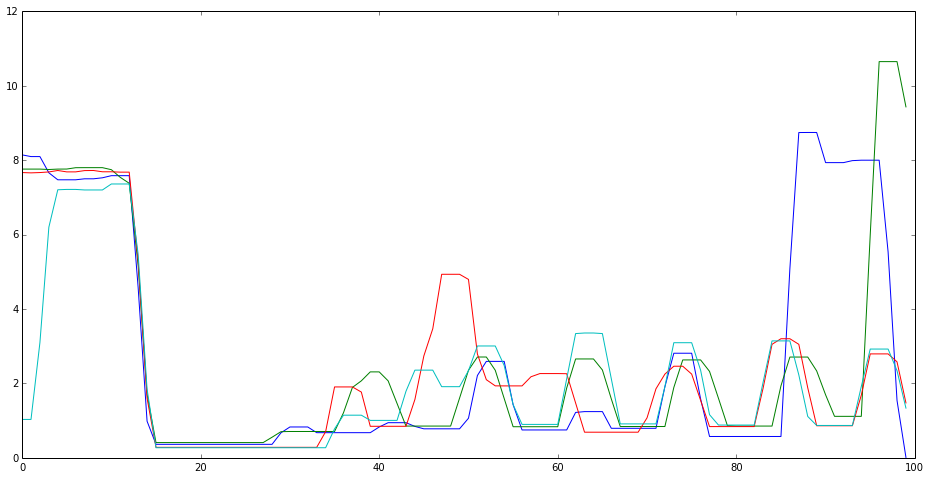

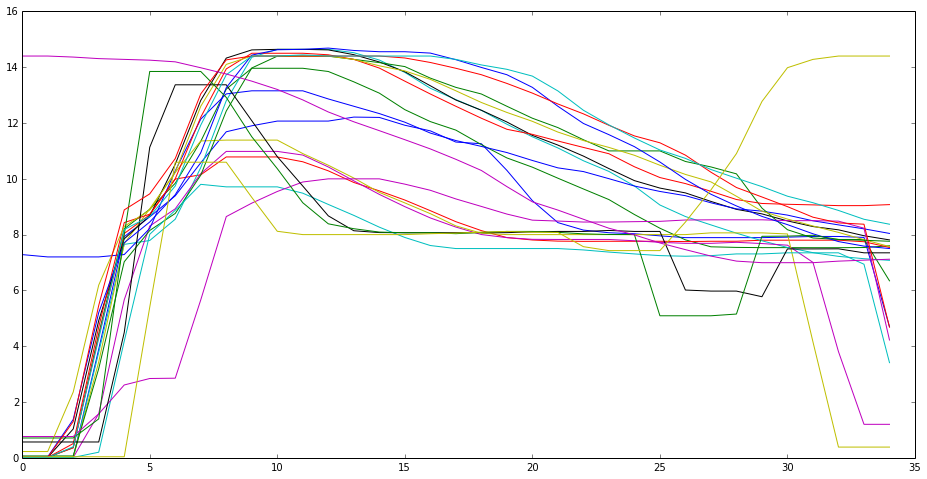

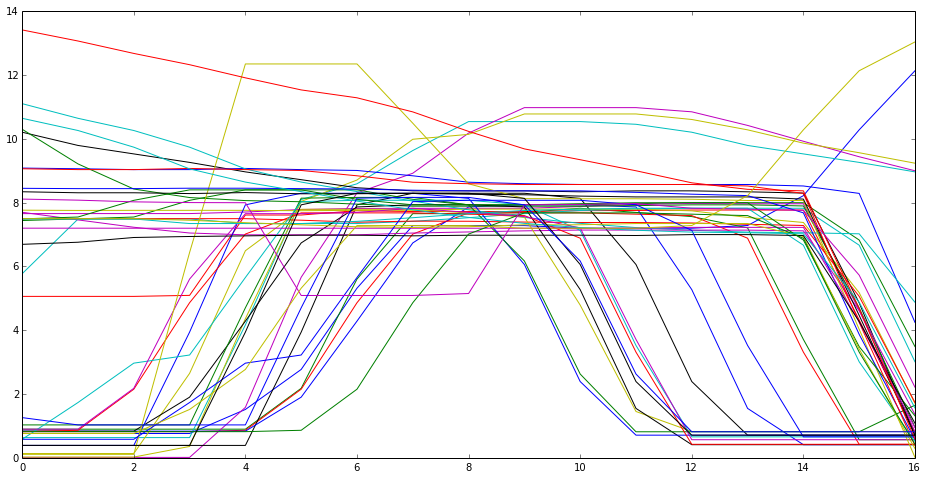

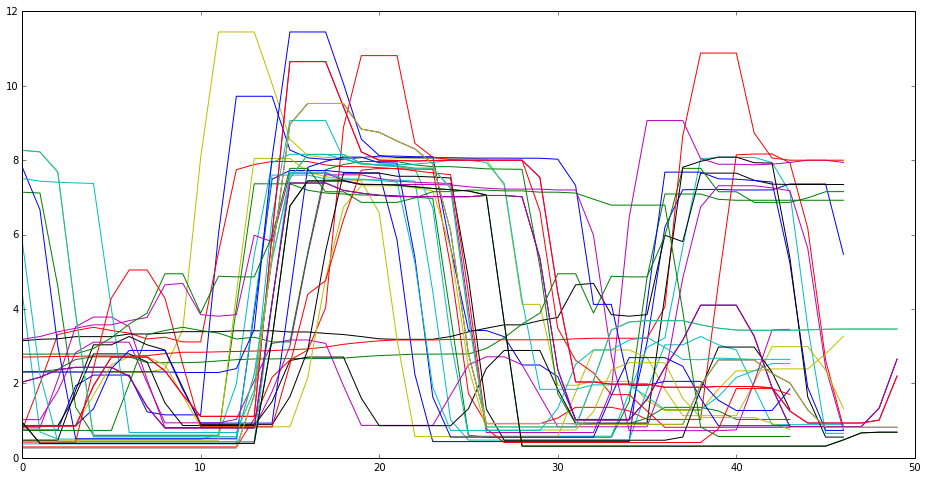

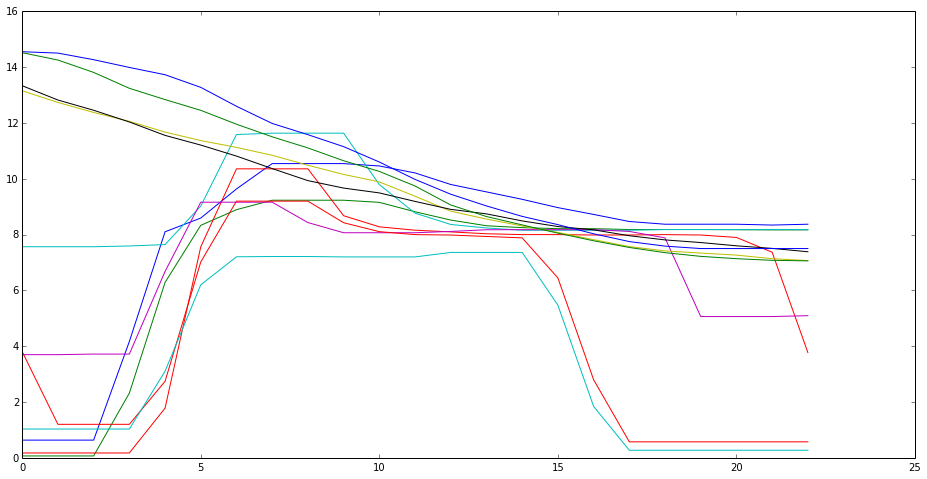

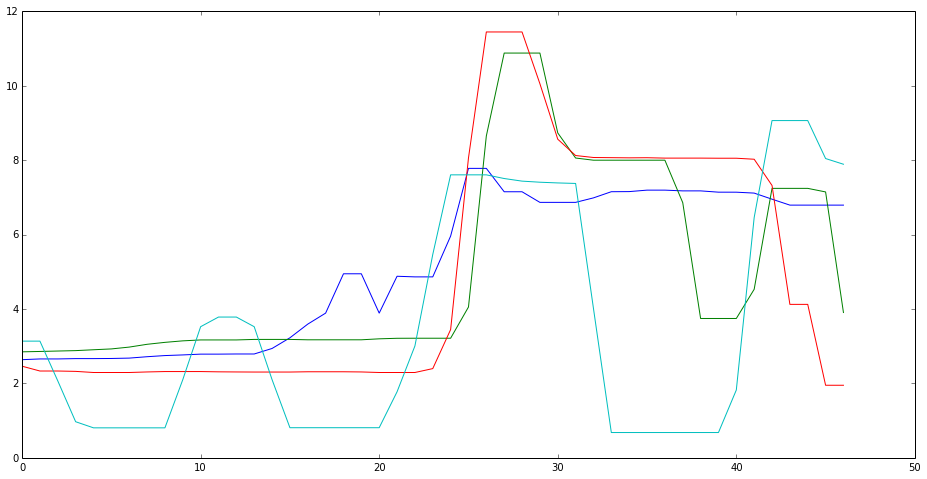

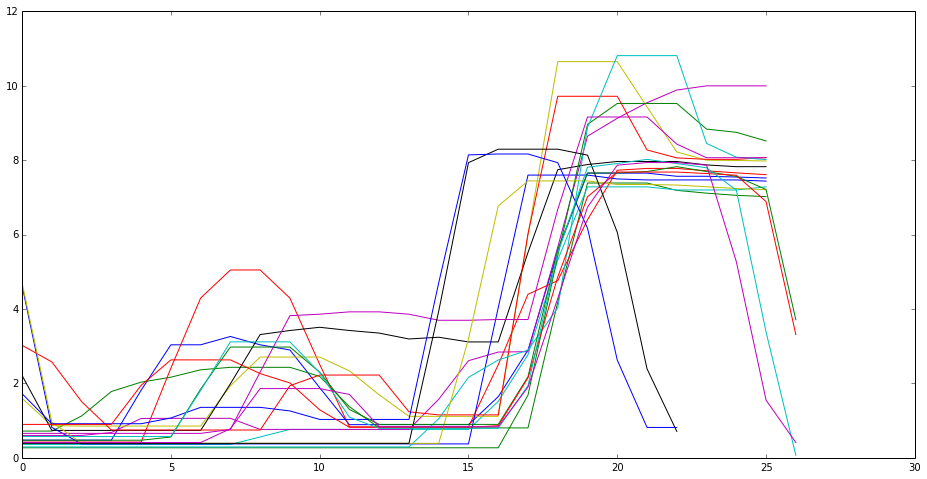

In [36]:
plot_types(df_types, df_rm)

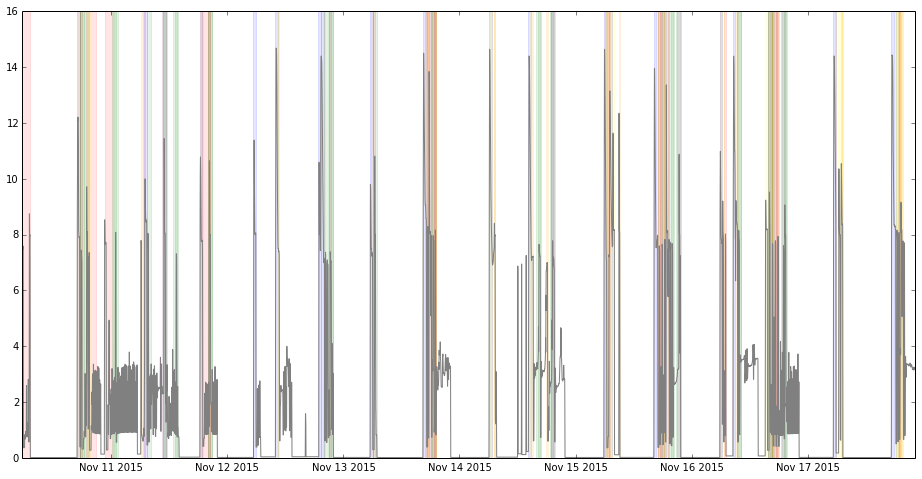

In [37]:
plot_coverage(df_types, df_rm)